In [20]:
from typing import List, Optional, Callable, Iterable
from itertools import islice

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from gluonts.dataset.repository import get_dataset
from gluonts.dataset.pandas import PandasDataset

In [21]:
dataset = get_dataset("electricity")


In [83]:
from collections.abc import Iterable
isinstance(dataset.train,Iterable)

True

In [88]:
for item in dataset.train:
    print(item)

{'target': array([14., 18., 21., ...,  6.,  9.,  7.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([0], dtype=int32), 'item_id': 0}
{'target': array([ 69.,  92.,  96., ..., 110., 115., 119.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([1], dtype=int32), 'item_id': 1}
{'target': array([234., 312., 312., ...,   8.,  10.,   8.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([2], dtype=int32), 'item_id': 2}
{'target': array([415., 556., 560., ..., 386., 440., 584.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([3], dtype=int32), 'item_id': 3}
{'target': array([215., 292., 272., ..., 188., 194., 208.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([4], dtype=int32), 'item_id': 4}
{'target': array([1056., 1363., 1240., ...,  566.,  659.,  818.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'f

In [82]:
for idx, entry in enumerate(islice(dataset.train, 9)):
    print(entry)

{'target': array([14., 18., 21., ...,  6.,  9.,  7.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([0], dtype=int32), 'item_id': 0}
{'target': array([ 69.,  92.,  96., ..., 110., 115., 119.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([1], dtype=int32), 'item_id': 1}
{'target': array([234., 312., 312., ...,   8.,  10.,   8.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([2], dtype=int32), 'item_id': 2}
{'target': array([415., 556., 560., ..., 386., 440., 584.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([3], dtype=int32), 'item_id': 3}
{'target': array([215., 292., 272., ..., 188., 194., 208.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'feat_static_cat': array([4], dtype=int32), 'item_id': 4}
{'target': array([1056., 1363., 1240., ...,  566.,  659.,  818.], dtype=float32), 'start': Period('2012-01-01 00:00', 'H'), 'f

Ici on a bien un itérable et à chaque fois une time series differente.. un peu bizarre ? 

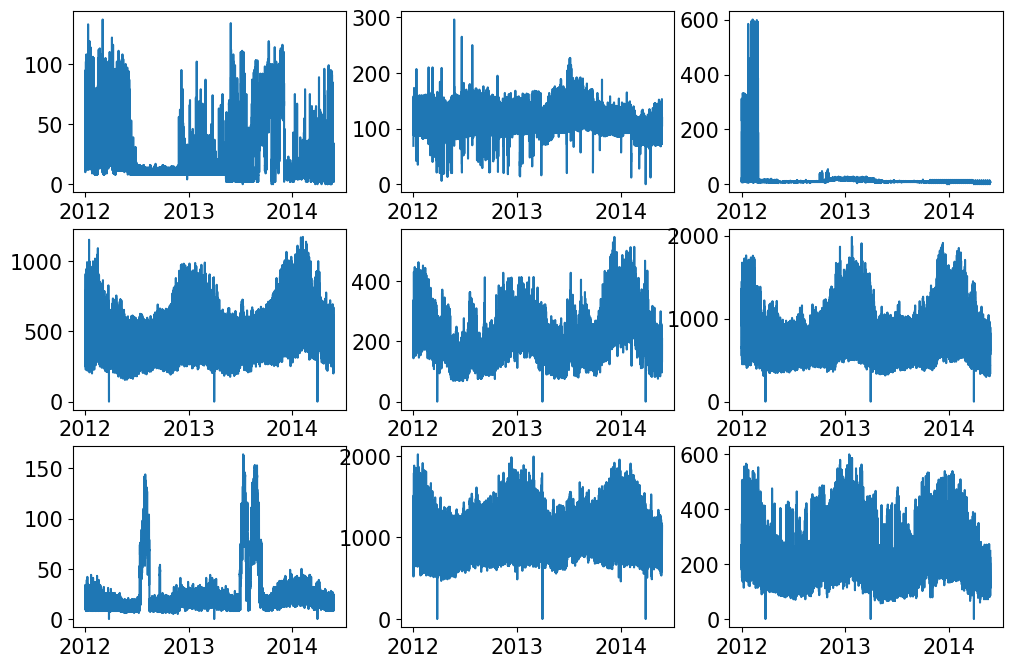

In [41]:
date_formater = mdates.DateFormatter("%Y")

fig = plt.figure(figsize=(12, 8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx + 1)
    t = pd.date_range(
        start=entry["start"].to_timestamp(),
        periods=len(entry["target"]),
        freq=entry["start"].freq,
    )
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

In [125]:
# Création de multiples séries temporelles avec des prix pour plusieurs actions
num_series = 5  # Nombre de séries temporelles différentes (par exemple, 5 actions différentes)

# Génération des identifiants pour les séries (actions) - de 1 à num_series
item_ids = [f'item_{i}' for i in range(1, num_series + 1)]

# Création d'une liste de DataFrames pour chaque série
dfs = []
for item_id in item_ids:
    # Générer des prix aléatoires pour chaque série temporelle
    prices = np.random.uniform(low=50, high=150, size=len(dates))
    
    # Créer un DataFrame pour chaque série avec un identifiant unique (item_id)
    df_item = pd.DataFrame(data={'item_id': item_id, 'price': prices}, index=dates)
    dfs.append(df_item)

# Concaténer toutes les séries temporelles dans un seul DataFrame (format long)
long_df = pd.concat(dfs)
long_df

,item_id,price
2010-01-01,item_1,131.082054
2010-01-02,item_1,93.707808
2010-01-03,item_1,62.388057
2010-01-04,item_1,106.444184
2010-01-05,item_1,145.230138
...,...,...
2012-12-27,item_5,89.423774
2012-12-28,item_5,96.817776
2012-12-29,item_5,140.626579
2012-12-30,item_5,143.070399


# customising the network 

In [22]:
from gluonts.torch.distributions import StudentTOutput              
from training.feedForwardNetwork import LightningFeedForwardNetwork 

In [23]:
context_length = 2 * 7 * 24 #peut varier à priori 
prediction_length = 6#dataset.metadata.prediction_length #24
hidden_dimensions = [96, 48,25] #on precise ici la derniere couche. 

In [66]:
#for p in net.parameters():
 #   print(p.shape)

## Defining the training data loader

In [24]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddObservedValuesIndicator,
    InstanceSplitter,
    ExpectedNumInstanceSampler,
    TestSplitSampler,
)
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify

In [25]:
context_length = 24
prediction_length = 6
batch_size = 32
num_batches_per_epoch = 50

In [26]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [155]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [156]:
#Construct an iterator of batches for training purposes.
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

In [167]:
import lightning.pytorch as pl

#lightingFeedForwardNetwork -- il initialise le reseau de neurones. 
net = LightningFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=[96,48,27],
    distr_output=StudentTOutput(),
) #network. Via le lightingFeedNetwork 

trainer = pl.Trainer(max_epochs=50)
trainer.fit(net, data_loader) #net est construit ici 

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | nn        | Sequential | 15.0 K | train
1 | args_proj | PtArgProj  | 84     | train
-------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | nn        | Sequential | 15.0 K | train
1 | args_proj | PtArgProj  | 84     | train
-------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [158]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [159]:
predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter) #le predictor est une des deux classes abstraites les plus importantes de GluonTS

In [160]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [165]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

#
forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)

/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/mxnet/numpy/utils.py:37: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  bool = onp.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

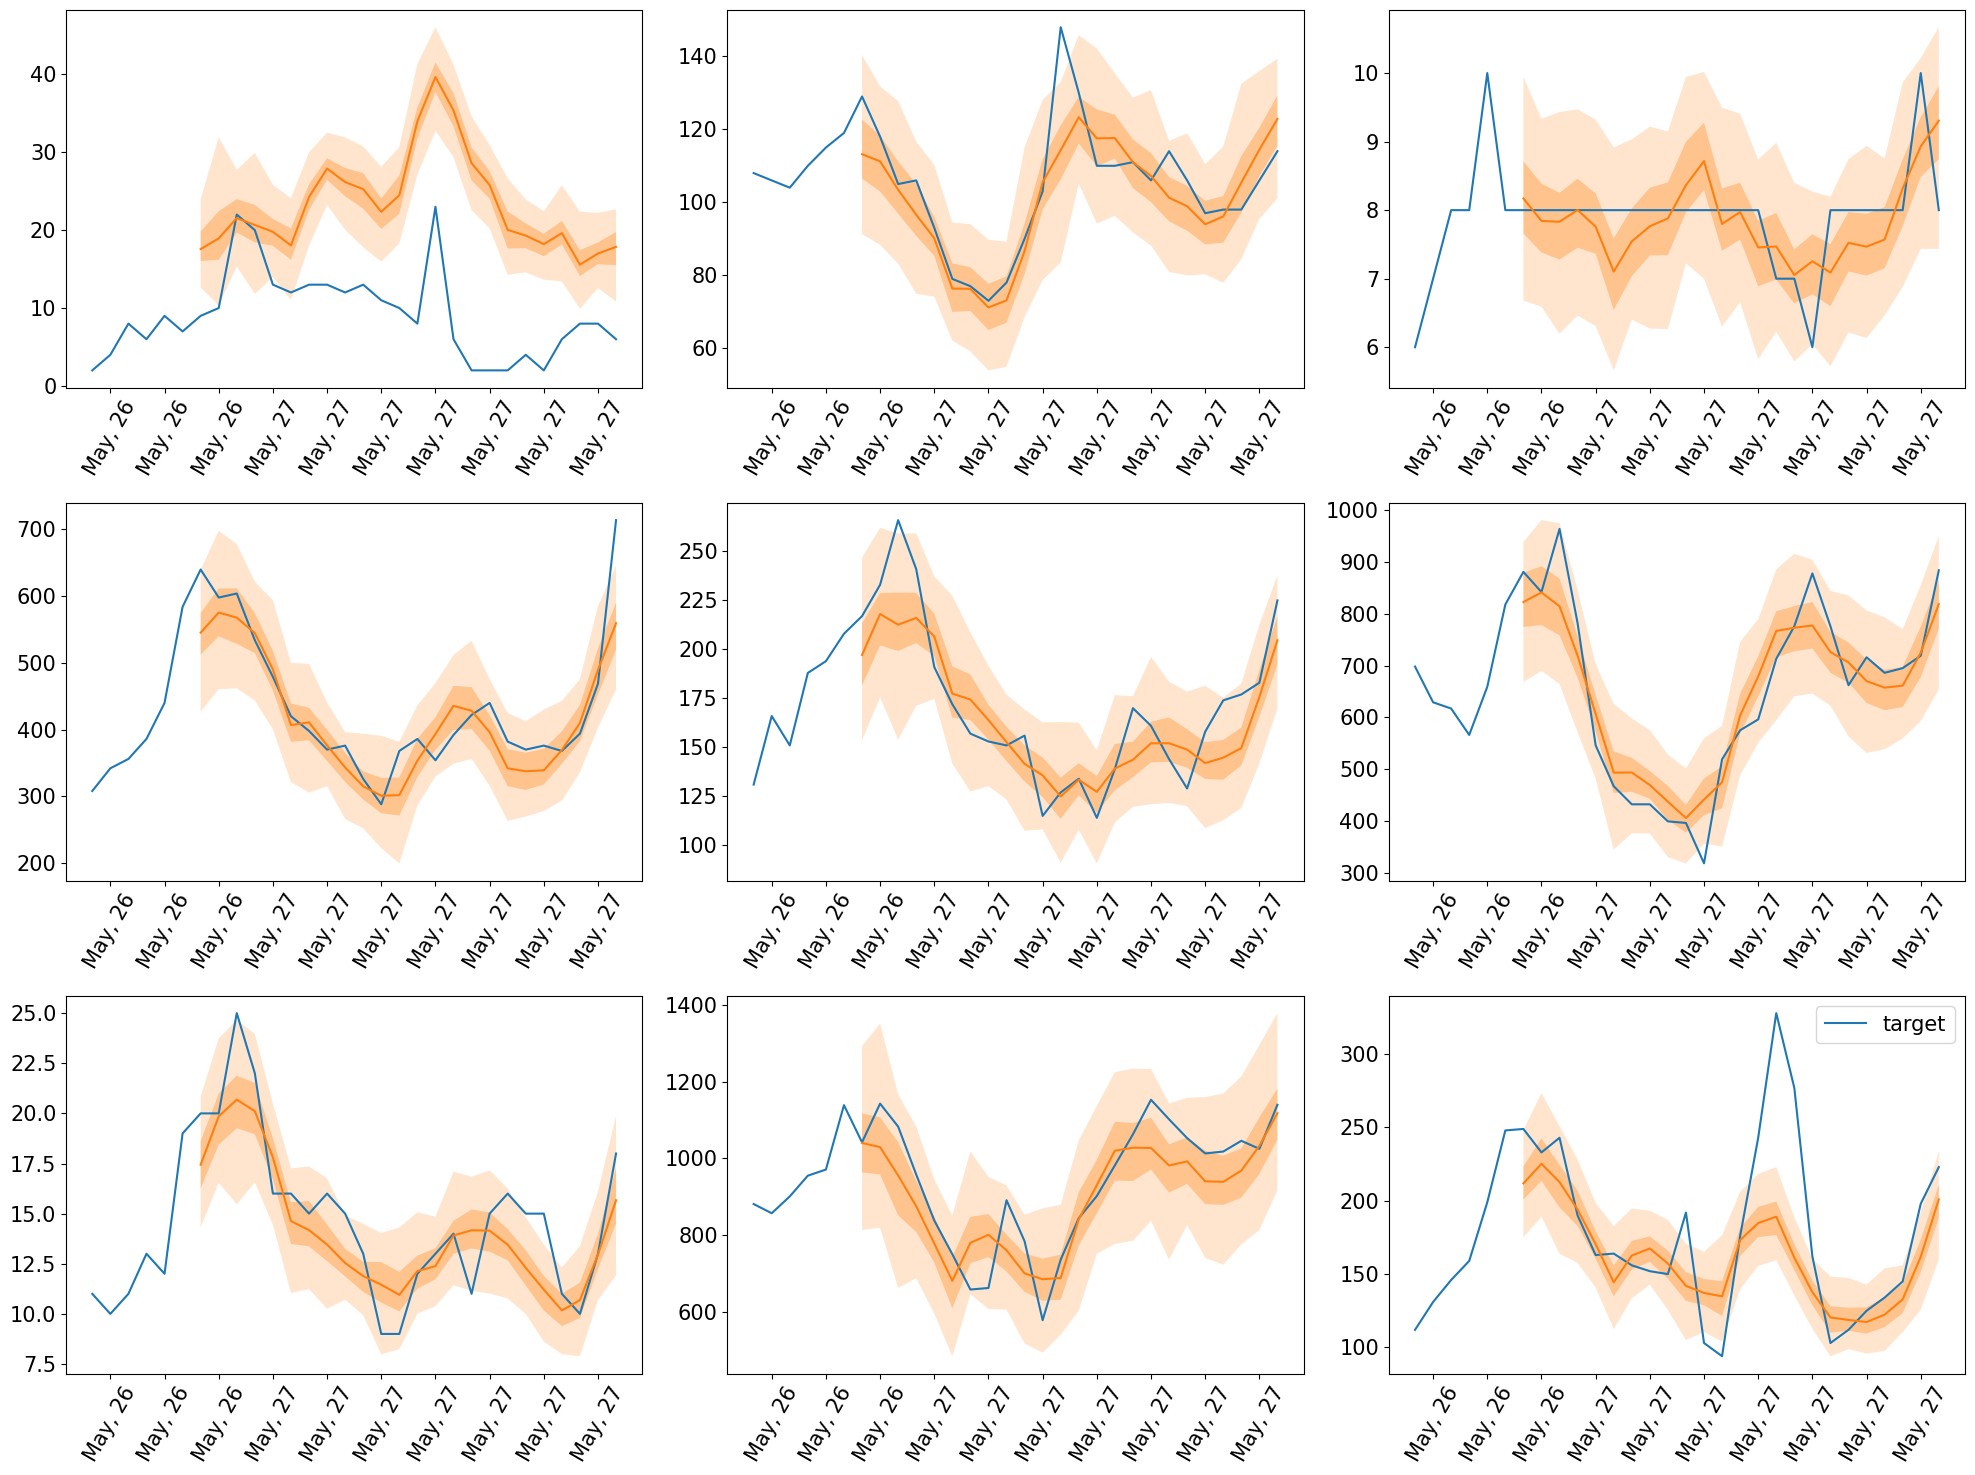

In [166]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-5 * prediction_length :].to_timestamp(), label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [58]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [59]:
metrics_pytorch, _ = evaluator(tss_pytorch, forecasts_pytorch)
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()

Running evaluation: 2247it [00:00, 10794.52it/s]
/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/gluonts/evaluation/_base.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/gluonts/evaluation/_base.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/gluonts/evaluation/_base.py:426: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/gluonts/evaluation/_base.py:426: RuntimeWarning:

,FeedForward
Coverage[0.1],9.729640e-02
Coverage[0.5],4.800289e-01
Coverage[0.9],8.844385e-01
MAE_Coverage,3.948128e-01
MAPE,1.544903e-01
MASE,1.009000e+00
MSE,3.238858e+06
MSIS,8.436118e+00
ND,9.372851e-02
NRMSE,7.544978e-01


# test 

In [27]:
#import optuna
import torch
from gluonts.dataset.split import split
from gluonts.evaluation import Evaluator
#from gluonts.torch.model.deepar import DeepAREstimator #
from deepar import DeepAREstimator
from simple_feedforward import SimpleFeedForwardEstimator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository import get_dataset
from gluonts.dataset.util import to_pandas
import numpy as np

# Création d'un alias local pour palier l'erreur
np.bool = bool

In [28]:
dataset = get_dataset("m4_hourly")

In [29]:
deepAREstimator = DeepAREstimator(
    num_layers= 4,
    hidden_size=46,
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer_kwargs={
        "enable_progress_bar": False,
        "enable_model_summary": False,
        "max_epochs": 30,
    },
)


estimatorMLP = SimpleFeedForwardEstimator(prediction_length=dataset.metadata.prediction_length,
                                          context_length=100,
                                          hidden_dimensions=[30,20,10],
                                          trainer_kwargs={
                                                "enable_progress_bar": False,
                                                "enable_model_summary": False,
                                                "max_epochs": 30,
                                            }
                                            )

In [31]:
predictorDeepAR = deepAREstimator.train(dataset.train, cache_data=True)
predictorMLP = estimatorMLP.train(dataset.train, cache_data=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Epoch 0, global step 50: 'train_loss' reached 5.30136 (best 5.30136), saving model to '/Users/adriencortes/Documents/20-TimeSeriesFeatRehm/gluonTSDemo/gluonTS/gluonTS/lightning_logs/version_23/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.05742 (best 5.05742), saving model to '/Users/adriencortes/Documents/20-TimeSeriesFeatRehm/gluonTSDemo/gluonTS/gluonTS/lightning_logs/version_23/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 4.86198 (best 4.86198), saving model to '/Users/adriencortes/Documents/20-TimeSeriesFeatRehm/gluonTSDemo/gluonTS/gluonT

In [13]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictorMLP,
)

In [14]:
forecasts = list(forecast_it)
tss = list(ts_it)

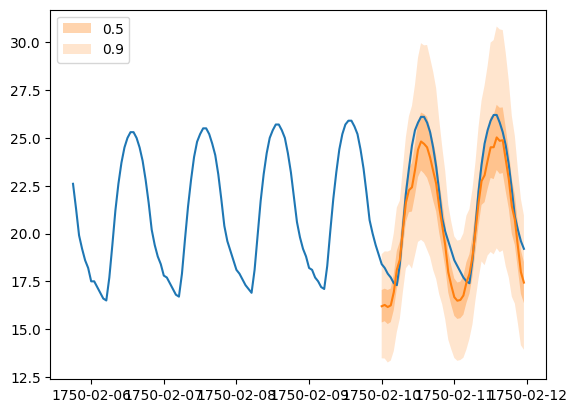

In [18]:
i = np.random.randint(0,len(forecasts))
plt.plot(tss[i][-150:].to_timestamp())
forecasts[i].plot(show_label=True)
plt.legend()

# evaluation and comparison of the differents models ? 

https://www.kaggle.com/code/snnclsr/gluonts-deepar-model-with-validation 

In [19]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 414it [00:00, 1408.80it/s]


{
    "MSE": 3730002.358924612,
    "abs_error": 7293367.650337219,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.394106280552918,
    "MAPE": 0.21888272137337647,
    "sMAPE": 0.18974490066309388,
    "MSIS": 45.540496266528606,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 5211448.8981872555,
    "Coverage[0.1]": 0.024355877616747183,
    "QuantileLoss[0.5]": 7293367.639891148,
    "Coverage[0.5]": 0.2722423510466989,
    "QuantileLoss[0.9]": 4112877.2982444763,
    "Coverage[0.9]": 0.8712761674718197,
    "RMSE": 1931.3214022851328,
    "NRMSE": 0.26366803063110167,
    "ND": 0.05010596723535283,
    "wQuantileLoss[0.1]": 0.035803033695855545,
    "wQuantileLoss[0.5]": 0.05010596716358756,
    "wQuantileLoss[0.9]": 0.028255766749854687,
    "mean_absolute_QuantileLoss": 5539231.278774293,
    "mean_wQuantileLoss": 0.038054922536432605,
    "MAE_Coverage": 0.39042538915727326,